### Bib Detector 
##### Informatics 4000 Mini-Project #3

An application that leverages deep learning models for vision-based race number detection and gender classification.

*****************************************************************************************************************************

**Datasets used in this application:**

- **'bib-numbers'**- I combined two datasets: [OCR Racing Bib Number Recognition](https://www.kaggle.com/datasets/trainingdatapro/ocr-race-numbers/) and [RBNR](https://people.csail.mit.edu/talidekel/RBNR.html).
- **'gender'** - I used a [dataset downloaded from Kraggle](https://www.kaggle.com/datasets/maciejgronczynski/biggest-genderface-recognition-dataset). 

Both datasets have around a 70/30 split of data between training and testing sets, respectively.

In [87]:
import os
import torch 

In [88]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [89]:
# FILE COUNT FOR 'bib-numbers'

# Parent directory containing the 'bib-numbers' subdirectory
parent_directory = 'datasets'

# List of subdirectories
subdirectories = ['train', 'test']

# Iterate through the subdirectories to count the files
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(parent_directory, 'bib-numbers', subdirectory)
    file_count = sum([len(files) for _, _, files in os.walk(subdirectory_path)])
    print(f"Number of files in '{subdirectory}' directory: {file_count}")

# Calculate the total number of files
total_train_files = sum([len(files) for _, _, files in os.walk(os.path.join(parent_directory, 'bib-numbers', 'train'))])
total_test_files = sum([len(files) for _, _, files in os.walk(os.path.join(parent_directory, 'bib-numbers', 'test'))])

Number of files in 'train' directory: 121
Number of files in 'test' directory: 52


In [90]:
# FILE COUNT FOR 'gender'

# List of categories
categories = ['man', 'woman']

# Iterate through the subdirectories and categories to count the files
for subdirectory in subdirectories:
    print(f"\nSubdirectory: {subdirectory}")
    for category in categories:
        category_path = os.path.join(parent_directory, 'gender', subdirectory, category)
        file_count = sum([len(files) for _, _, files in os.walk(category_path)])
        print(f"{category}: {file_count} files")



Subdirectory: train


man: 12374 files


KeyboardInterrupt: 

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
from PIL import Image


image 1/1 /Users/maddiehope/Desktop/bib-detector/datasets/bib-numbers/test/01.JPG: 640x480 3 persons, 196.1ms
Speed: 7.8ms preprocess, 196.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 480)


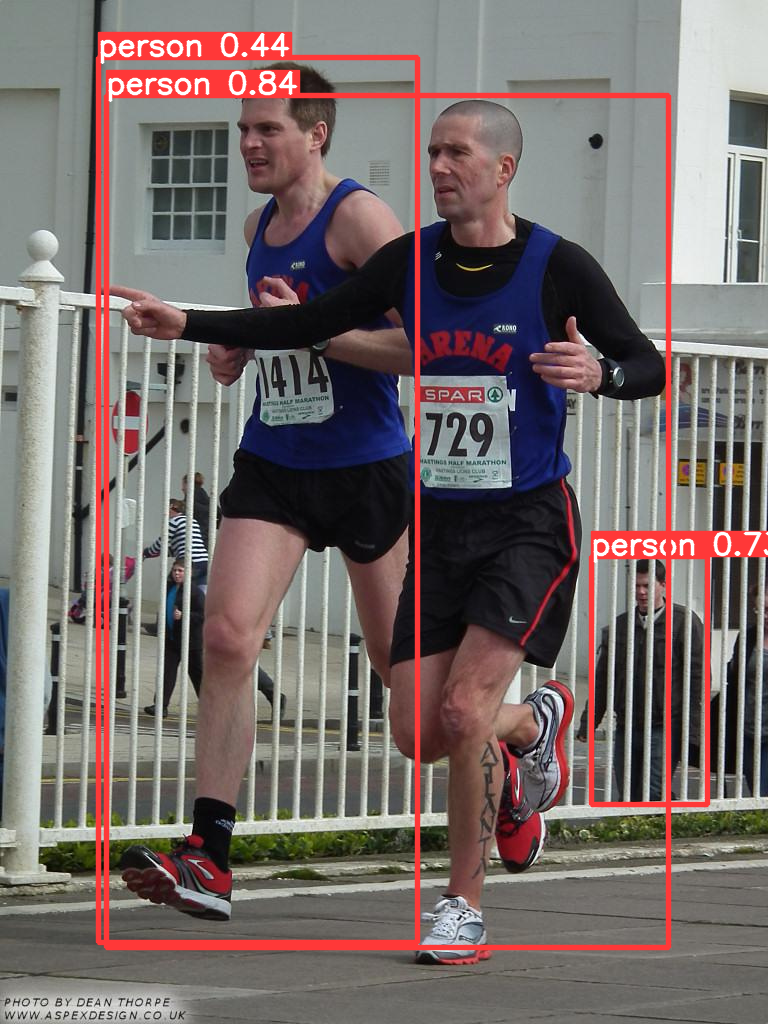

In [ ]:
# * The following is modified from an example: *

# Load a pretrained YOLOv8n model
model_people = YOLO('yolov8n.pt') 

# Make the only detection class be 'person'
model_people.classes = ['person']

# Run inference on 'bus.jpg'
results = model_people('/Users/maddiehope/Desktop/bib-detector/datasets/bib-numbers/test/01.JPG')  # results list

# Show the results
for r in results:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    display(im) # show image in output 

As you can see in the image above, YOLOv8n can detect people. Now we have to figure out how to make it detect bibs & numbers within this bibs.

In order to do this, I will need to annotate my training data so that boundary boxes are drawn around the bibs shown in every image. This will help the model learn what exactly a bib is. 

For the next steps of this process, this [guide on Roboflow](https://blog.roboflow.com/how-to-train-yolov8-on-a-custom-dataset/) was beneficial to me. I also referenced the [Ultralytics website](https://docs.ultralytics.com) often.

The first step is to annotate my training images so that the 'bib' class of objects are clearly boxed in for the model to see and train on. I used the **Roboflow Annotator** to do this.

In [ ]:
from roboflow import Roboflow

In [ ]:
# Dataset Download Parameters

rf = Roboflow(api_key="yYpsVAGAUqStCCpiXk8k")

project = rf.workspace("university-of-georgia-k4dwo").project("bib-detection-sinjn")

dataset = project.version(1).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Bib-Detection--1 in yolov5pytorch:: 100%|██████████| 355/355 [00:00<00:00, 706.57it/s]


*****************************************************************************************************************************

**NOTE**: before you can run the code below, you have to go into **'Bib-Detection--1/data.yaml'** and **CHANGE** this line of code: 

##### **val: Bib-Detection--1/valid/images**

changes to:

##### **val:**

There is **NO validation data in this dataset**. I am not sure how to stop the valid section from downloading through Roboflow, so inbewteen running the cell above and the cell below you must manually make this change or you will get an error.

You will probably also have to edit the train and test paths in this file, as they will be different for your computer.

*****************************************************************************************************************************

For reference, here is the text in my 'data.yaml' looks like before the following cell is able to run properly:

In [ ]:
'''

names:
- Bib
nc: 1
roboflow:
  license: MIT
  project: bib-detection-sinjn
  url: https://universe.roboflow.com/university-of-georgia-k4dwo/bib-detection-sinjn/dataset/1
  version: 1
  workspace: university-of-georgia-k4dwo
test: /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/test
train: /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/train
val:

'''

'\n\nnames:\n- Bib\nnc: 1\nroboflow:\n  license: MIT\n  project: bib-detection-sinjn\n  url: https://universe.roboflow.com/university-of-georgia-k4dwo/bib-detection-sinjn/dataset/1\n  version: 1\n  workspace: university-of-georgia-k4dwo\ntest: /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/test\ntrain: /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/train\nval:\n\n'

Now I can begin the training process through YOLO using my custom dataset:

In [ ]:
model_bib = YOLO('yolov8n.pt')

model_bib = model_bib.train(data= f"{dataset.location}/data.yaml" , epochs=100, imgsz=640, device='cpu')

Ultralytics YOLOv8.0.209 🚀 Python-3.9.18 torch-1.12.1 CPU (Intel Core(TM) i5-8257U 1.40GHz)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train15, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=Fa

I am not exactly sure why I am getting the error "warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')", becuase the device is specificed to be 'cpu'.

*****************************************************************************************************************************

**NOTE**: you will have to change the following file path to the model below to wherever the best weights saved on your computer. 

At the end of the cell ouput above, it gives me this statement:

#### **Validating /Users/maddiehope/runs/detect/train15/weights/best.pt...**

This was the file path I used below to create my model object.

*****************************************************************************************************************************

Now we can evaluate the performance metrics of this model:

In [ ]:
model_bib = YOLO("/Users/maddiehope/runs/detect/train15/weights/best.pt") 

metrics = model_bib.val(data = f"{dataset.location}/data.yaml", split = "test")

print(f"\n")
print("Precision:", metrics.results_dict['metrics/precision(B)'])
print("Recall:", metrics.results_dict['metrics/recall(B)'])
print("mAP50:", metrics.results_dict['metrics/mAP50(B)'])
print("mAP50-95:", metrics.results_dict['metrics/mAP50-95(B)'])
print("Fitness:", metrics.results_dict['fitness'])

Ultralytics YOLOv8.0.209 🚀 Python-3.9.18 torch-1.12.1 CPU (Intel Core(TM) i5-8257U 1.40GHz)
val: Scanning /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/test/labels.cache... 52 images, 0 backgrounds, 0 corrupt: 100%|██████████| 52/52 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]
                   all         52        124      0.934      0.903      0.951      0.547
Speed: 5.0ms preprocess, 130.9ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /Users/maddiehope/runs/detect/val7




Precision: 0.9336284543004645
Recall: 0.9032258064516129
mAP50: 0.9510731129426865
mAP50-95: 0.5465752902845515
Fitness: 0.5870250725503651


The metrics on the model look great. Precision, recall, and mAP50 are all very high. mAP50-95 is lower, but it still isn't terrible. The overall fittness is also mid, but with the high precision I'm not upset.


image 1/52 /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/test/images/01_JPG.rf.e62f0206ee6fdfeb9519ad79791c38e6.jpg: 640x640 2 Bibs, 278.4ms
image 2/52 /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/test/images/02_JPG.rf.6b6e8af4c2d675705e2901a4f955adc6.jpg: 640x640 1 Bib, 124.5ms
image 3/52 /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/test/images/03_png.rf.8b75100491cd3982f280abb0ac5373d2.jpg: 640x640 4 Bibs, 115.2ms
image 4/52 /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/test/images/04_png.rf.06743e8f75445862c2afa1da7e7fbd78.jpg: 640x640 4 Bibs, 134.9ms
image 5/52 /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/test/images/05_JPG.rf.a0be7042ffafd212dbbf78d3675fbb58.jpg: 640x640 1 Bib, 139.4ms
image 6/52 /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/test/images/06_JPG.rf.0f03e35464b9f7c2acea2054bb99b281.jpg: 640x640 1 Bib, 141.7ms
image 7/52 /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/test/images/07_png.rf.faa67be

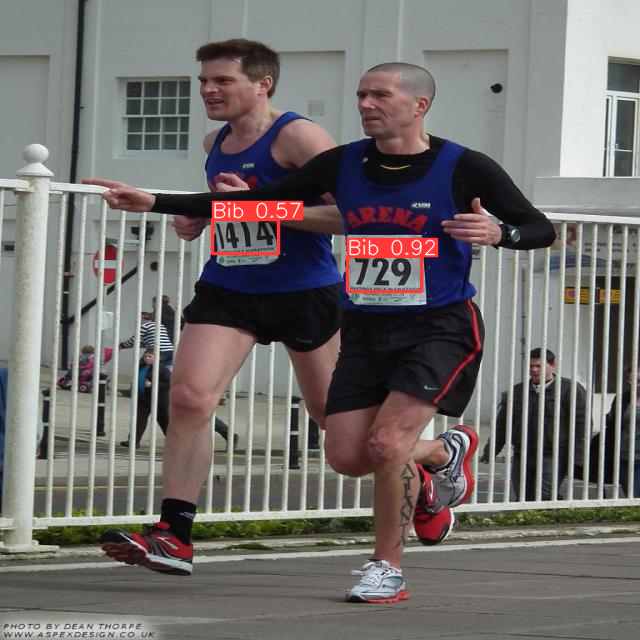

In [ ]:
results = model_bib.predict(source=f"{dataset.location}/test/images", conf=0.25) # conf is object confidence threshold, setting to 25%

# Show the results
# I will only display the first image in the testing set b/c that is the image we initally tried using model_people

results_1 = results[0]

im_array = results_1.plot()  # plot a BGR numpy array of predictions
im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
display(im) # show image in output 

Yay!! The model is now trained to detect bibs and the predictions look great! The next step is to create a pipeline of the people model & the bib model so that when given an image, it can detect both.

In [ ]:
import multiprocessing

In [ ]:
# Function to perform the object detection for each model
def detection(model, input_image, output_queue):

    # Perform object detection on the input image
    results = model(input_image)

    # Put the detection results into the output queue
    output_queue.put(results)

In [91]:
# Function the merge the two model results into one result
if __name__ == "__main__":

    input_image = cv2.imread('/Users/maddiehope/Desktop/bib-detector/datasets/bib-numbers/test/01.JPG')

    # Create separate output queues for each YOLOv8 model
    queue1 = Queue()
    queue2 = Queue()

    # Create separate processes for each YOLOv8 model
    process1 = Process(target=detection, args=(model_people, input_image, queue1 ))
    process2 = Process(target=detection, args=(model_bib, input_image, queue2 ))

    # Start the processes
    process1.start()
    process2.start()

    # Wait for the processes to finish
    process1.join()
    process2.join()

    # Retrieve the detection results from the output queues
    results1 = queue1.get()
    results2 = queue2.get()

    # Read the two output frames from the YOLOv8 models
    frame1 = cv2.imread('output_frame1.jpg')
    frame2 = cv2.imread('output_frame2.jpg')

    # Define the weight for each frame
    alpha = 0.5  # Weight for the first frame
    beta = 0.5   # Weight for the second frame

    # Merge the frames using addWeighted
    merged_frame = cv2.addWeighted(frame1, alpha, frame2, beta, 0)

    # Display or save the merged frame
    cv2.imshow('Merged Frame', merged_frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


TypeError: cannot pickle '_thread.lock' object

In [ ]:
merge('/Users/maddiehope/Desktop/bib-detector/datasets/bib-numbers/test/01.JPG') # same image used from model_people & model_bib prediction examples

TypeError: cannot pickle '_thread.lock' object